In [1]:
%run 'Functions.ipynb'

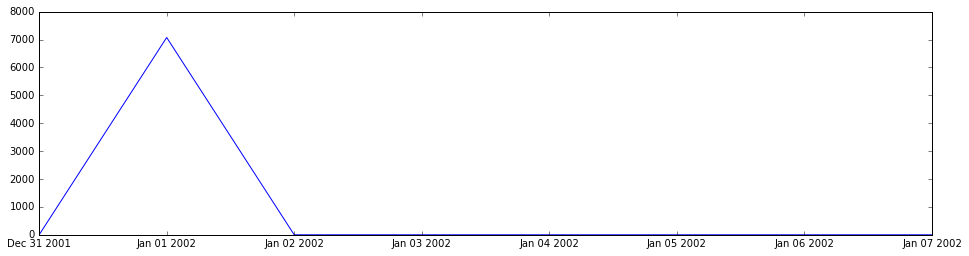

In [2]:
x, y = unzip(hist_data(None, '2001-12-30', '2002-01-08'))
y[y <= 100] = 0
plt.plot(x, y)

In [3]:
def hist_data_precise(terms=None, start='1900-01-01', end='2020-01-01', show_query=False):
    q = Search(index='hep-slim')[0:0] \
        .filter("script", script="d = doc['earliest_date'].date; d.getDayOfMonth() != 1") \
        .filter('range', earliest_date={'gte': start, 'lt': end})
    q.aggs.bucket(
        'group_by_date',
        'date_histogram',
        field='earliest_date',
        interval='day',
        format='date_optional_time'
    )
    if terms:
        q = q.query('match', abstract=terms)
    if show_query:
        print(q.to_dict())
    return q.execute().aggregations.group_by_date.buckets

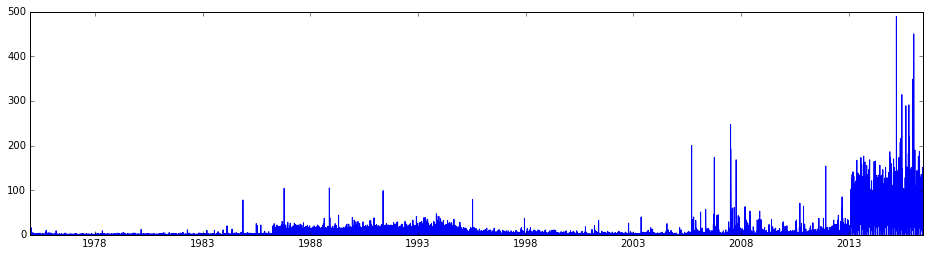

In [4]:
x, y = unzip(hist_data_precise(None, '1975-01-01', '2017-01-01'))
plt.plot(x, y)

In [35]:
def reverse_date_references(show_query=False):
    q = Search(index='hep-slim')[0:0] \
        .filter("script", script="d = doc['earliest_date'].date; d.getDayOfMonth() != 1")
    agg = q.aggs.bucket(
        'references',
        'terms',
        field='references.recid',
        size=0
    )
    agg.bucket('min_earliest_date', 'min', field='earliest_date')
    agg.bucket('min_preprint_date', 'min', field='preprint_date')
    agg.bucket('min_modification_date', 'min', field='creation_modification_date.modification_date')
    agg.bucket('min_creation_date', 'min', field='creation_modification_date.creation_date')
    if show_query:
        print(q.to_dict())
    res = q.execute().aggregations.references.buckets
    
    def extract_date(elem):
        return parse_iso_date(elem.value_as_string) if "value_as_string" in elem else None
    
    mappings = {}
    for elem in res:
        mappings[elem.key] = {
            'earliest_date': extract_date(elem.min_earliest_date),
            'preprint_date': extract_date(elem.min_preprint_date),
            'modification_date': extract_date(elem.min_modification_date),
            'creation_date': extract_date(elem.min_creation_date)
        }
    return mappings

In [37]:
recid_min_date_index = reverse_date_references()

TransportError: TransportError(500, 'reduce_search_phase_exception', 'Java heap space')

In [32]:
filtered = [e for e in list(recid_min_date_index.values()) if e['min_preprint_date'] is None]

In [33]:
len(filtered)

13398

In [34]:
len(recid_min_date_index)

214516